# AAM-IPL Week-6 Naive Bayes - Email Spam Classifier
**Implemented By**: Venkateswar Reddy Melachervu </br>
**Branch of Study**:CS-Core and CS-AI and ML </br>
**Department**: CSM </br>
**Semester**: V 2024-25 AY </br>
**Email**: venkat@brillium.in </br>
**Guest Faculty and Instructor**: Venkateswar Reddy Melachervu, CTO, Brillium Technologies </br>
**Program Coordinator**: Prof. V.Suresh, CSM, GPREC </br>

**Project Implementation Details**: </br>
As published in the project announcement in AAM-IPL Online Classroom


**AAM-IPL of GPREC is brought to you by Brillium Technologies.**

Preprocessing Time: 260.93 seconds
Total emails in the provided dataset: 10745
Spam emails: 3794
Genuine emails: 6951 

Total Unique Words: 152235
Total Word Count: 3799443
Alphabetically sorted word frequencies saved to word_frequency.txt

10 Words with the Highest Frequency:
the: 123686
to: 88557
a: 83987
and: 65986
of: 61502
d: 45411
you: 42720
in: 42275
i: 36878
is: 36272

Displaying one email with HTML tags and without HTML tags...

Original Email Content with HTML Tags:

Headers:
 From lmrn@mailexcite.com  Mon Jun 24 17:03:24 2002
Return-Path: merchantsworld2001@juno.com
Delivery-Date: Mon May 13 04:46:13 2002
Received: from mandark.labs.netnoteinc.com ([213.105.180.140]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4D3kCe15097 for
    <jm@jmason.org>; Mon, 13 May 2002 04:46:12 +0100
Received: from 203.129.205.5.205.129.203.in-addr.arpa ([203.129.205.5]) by
    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with SMTP id g4D3k2D12605 for
    <jm@netnoteinc.com>; Mon, 13 

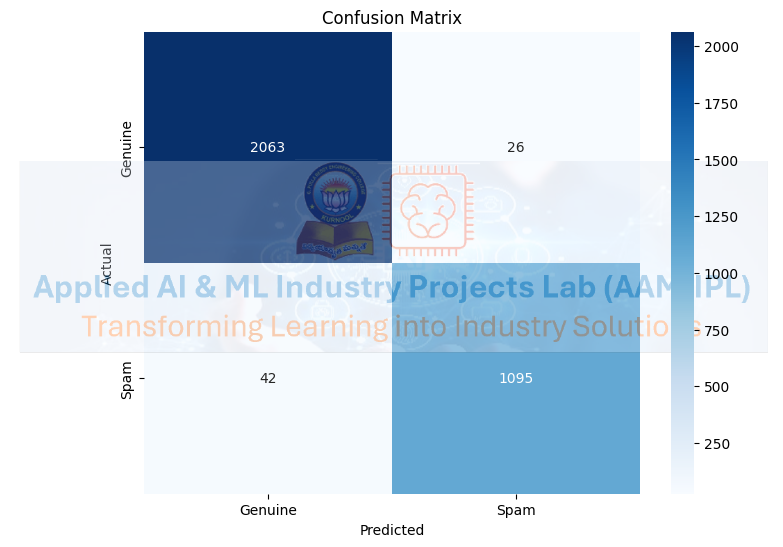

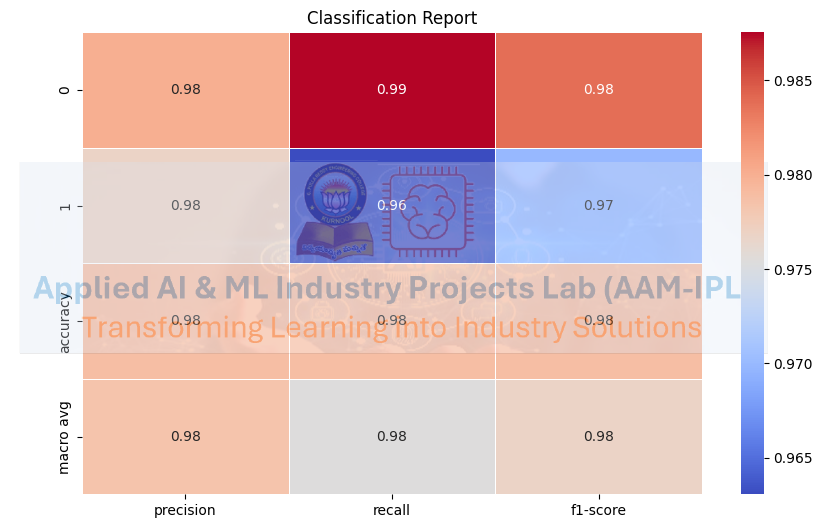

Word frequencies saved to word_frequency.txt


In [13]:
# Import required libraries
import os
import re
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Affine2D

# Path to the watermark image
aam_ipl_wama_image = 'AAM-IPL-Watermark-for-Plots.png'
data_prep_up_count = 0

# Function to add watermark diagonally with zoom and rotation
def add_aam_ipl_wama_revised(ax, watermark_path, zoom=0.5, alpha=0.3, rotation_angle=45):
    """
    Adds an image watermark diagonally to the provided axis.
    
    Parameters:
    - ax: The axis to add the watermark to.
    - watermark_path: The path to the image to use as the watermark.
    - zoom: The scale of the watermark image.
    - alpha: The transparency level for the watermark (default: 0.3).
    - rotation_angle: The angle to rotate the watermark (default: 45 degrees).
    """
    # Load the image from the file path
    watermark_image = Image.open(watermark_path)
    
    # Convert the PIL image to a format that OffsetImage can handle (numpy array)
    watermark_image_np = np.array(watermark_image)

    # Create the image box with specified transparency and zoom
    imagebox = OffsetImage(watermark_image_np, alpha=alpha, zoom=zoom)

    # Apply rotation and positioning (diagonal placement)
    trans_data = Affine2D().rotate_deg(rotation_angle) + ax.transData
    
    # Position the watermark at the center of the plot (0.5, 0.5) in axis fraction coordinates
    ab = AnnotationBbox(imagebox, (0.5, 0.5), frameon=False, xycoords='axes fraction', pad=0, transform=trans_data)
    
    # Add the watermark to the axis
    ax.add_artist(ab)

# Function to plot confusion matrix with watermark
def plot_confusion_matrix_with_watermark(y_test, y_pred, image_path, zoom=0.5):
    """Plot confusion matrix with a watermark."""
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Genuine', 'Spam']
    
    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Add watermark
    add_aam_ipl_wama_revised(ax, image_path, zoom=zoom)
    
    # Show plot
    plt.show()

# Function to plot classification report with watermark
def plot_classification_report_with_watermark(y_test, y_pred, image_path, zoom=0.5):
    """Plot classification report as a heatmap with a watermark."""
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Plotting classification report
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", linewidths=0.5, ax=ax)
    plt.title('Classification Report')
    
    # Add watermark
    add_aam_ipl_wama_revised(ax, image_path, zoom=zoom)
    
    # Show plot
    plt.show()

# Function to load emails from subdirectories and label them
def load_emails(folder, label):
    emails = []
    for root, _, files in os.walk(folder):  # Recursively walk through all subdirectories
        for filename in files:
            try:
                with open(os.path.join(root, filename), 'r', encoding='latin1') as f:
                    emails.append((f.read(), label))
            except UnicodeDecodeError:
                print(f"Could not decode file: {filename}")
    return emails

# Function to display HTML and plain text versions side by side
def display_email_content(email_text):
    # Split headers and body
    headers, body = re.split(r'\n\n', email_text, maxsplit=1)
    
    # Extract subject
    subject_match = re.search(r'Subject: (.*)', headers)
    subject = subject_match.group(1) if subject_match else "(No Subject)"
    
    # Check for HTML tags
    if bool(re.search(r'<(/?)(html|body|p|div|a|span|table|img)', body, re.IGNORECASE)):
        # Clean HTML from the body
        body_without_html = BeautifulSoup(body, "html.parser").get_text()
        
        # Display email content with and without HTML tags
        print("Original Email Content with HTML Tags:\n")
        print("Headers:\n", headers)
        print("\nSubject:\n", subject)
        print("\nBody:\n", body)
        
        print("\n" + "="*80 + "\n")
        
        print("Email Content without HTML Tags:\n")
        print("Headers:\n", headers)
        print("\nSubject:\n", subject)
        print("\nBody:\n", body_without_html)
        return True
    return False

# Function to process and clean the email content
def clean_email(text):
    # Remove HTML tags if present
    text = BeautifulSoup(text, "html.parser").get_text()
    # Extract subject if available
    subject_match = re.search(r'Subject: (.*)', text)
    subject = subject_match.group(1) if subject_match else ""
    # Remove header lines and keep body
    body = re.split(r'\n\n', text, maxsplit=1)[-1]  # Split on first double newline to separate header
    # Remove URLs, email addresses, and unnecessary characters
    body = re.sub(r"http\S+|www\S+|mailto:\S+", " ", body)  # Remove URLs
    body = re.sub(r'\S+@\S+', ' ', body)  # Remove email addresses
    body = re.sub(r'[^a-zA-Z]', ' ', body)  # Keep only letters
    # Lowercase and combine subject and body
    cleaned_text = (subject + " " + body).lower()
    return cleaned_text

# Function to preprocess the dataset and prepare it for training
def prepare_data(spam_dir, genuine_dir):
    # Start timing for preprocessing
    start_time = time.time()
    
    # Load spam and genuine emails
    spam_emails = load_emails(spam_dir, 1)
    genuine_emails = load_emails(genuine_dir, 0)
    
    # Combine and create a DataFrame
    data = pd.DataFrame(spam_emails + genuine_emails, columns=['email', 'label'])
    
    # Clean and preprocess the email content
    data['cleaned_email'] = data['email'].apply(clean_email)
    
    # Measure preprocessing time
    preprocessing_time = time.time() - start_time
    print(f"Preprocessing Time: {preprocessing_time:.2f} seconds")
    
    return data

# Function to vectorize data using TF-IDF
def vectorize_data(data):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vectorizer.fit_transform(data['cleaned_email'])
    return X, data['label'], vectorizer

# Function to train a Naive Bayes model
def train_naive_bayes(X_train, y_train):
    # Start timing for training
    start_time = time.time()
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    # Measure training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Function to calculate word frequencies
def calculate_word_frequencies(data):
    all_words = ' '.join(data['cleaned_email']).split()
    word_freq = Counter(all_words)
    return word_freq

# Function to save word frequencies to a file
def save_word_frequencies(word_freq, filename='word_frequency.txt'):
    sorted_word_freq = dict(sorted(word_freq.items()))
    with open(filename, 'w') as f:
        for word, freq in sorted_word_freq.items():
            f.write(f"{word}: {freq}\n")
    print(f"Word frequencies saved to {filename}")
    
# Main function to execute all steps with classification report and confusion matrix plotting
def main():   
    # Set paths for the smaller spam and genuine directories
    small_spam_dir = os.path.join('small-dataset', 'spam')    # replace with actual path if needed
    small_genuine_dir = os.path.join('small-dataset', 'genuine')  # replace with actual path if needed

    # Set paths for the larger spam and genuine directories
    large_spam_dir = os.path.join('mail-dataset', 'spam')    # replace with actual path if needed
    large_genuine_dir = os.path.join('mail-dataset', 'genuine')  # replace with actual path if needed

    #spam_dir = small_spam_dir
    #genuine_dir = small_genuine_dir
    
    spam_dir = large_spam_dir
    genuine_dir = large_genuine_dir
    
    data_prep_up_count = 0
    # Prepare data
    if data_prep_up_count < 1:
        data = prepare_data(spam_dir, genuine_dir)
        data_prep_up_count = data_prep_up_count + 1 
    #data = prepare_data(spam_dir, genuine_dir)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data['cleaned_email'], data['label'], test_size=0.3, random_state=42)
    
    # Vectorize the data
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Build the Dictionary and Word Frequency
    # Create a dictionary with word frequencies from the entire dataset
    all_words = ' '.join(data['cleaned_email']).split()
    word_freq = Counter(all_words)

    # Find the count of spam and genuine email files in mail-dataset
    # Set the path to the dataset directory
    dataset_path = "mail-dataset"

    # Initialize counters
    spam_count = 0
    genuine_count = 0
    
    # Walk through the directory structure, counting files in spam and genuine subdirectories
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Match files starting with a number, followed by a dot and any other characters
            if re.match(r'^\d+\.\w+', file):
                # Check if the file is in a folder named "spam" or "genuine" in any level of hierarchy
                if "spam" in root.lower():
                    spam_count += 1
                elif "genuine" in root.lower():
                    genuine_count += 1

    # Calculate the total count
    total_count = spam_count + genuine_count

    # Print the counts
    print("Total emails in the provided dataset:", total_count)
    print("Spam emails:", spam_count)
    print("Genuine emails:", genuine_count, "\n")

    # Calculate total unique word count and total word count in the dataset
    total_unique_words = len(word_freq)
    total_word_count = sum(word_freq.values())

    # Print the counts to the console
    print(f"Total Unique Words: {total_unique_words}")
    print(f"Total Word Count: {total_word_count}")

    # Sort the dictionary by word (alphabetical order)
    sorted_word_freq = dict(sorted(word_freq.items()))

    # Write the sorted word frequencies to a file
    with open('word_frequency.txt', 'w') as f:
        for word, freq in sorted_word_freq.items():
            f.write(f"{word}: {freq}\n")

    print("Alphabetically sorted word frequencies saved to word_frequency.txt")

    # Display the first 10 words with their frequencies
    # Sort the word frequencies by frequency in descending order
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    # Now display the top 10 words
    print("\n10 Words with the Highest Frequency:")
    for word, freq in top_words:
        print(f"{word}: {freq}")

    # Display an email with HTML content
    print("\nDisplaying one email with HTML tags and without HTML tags...\n")
    for email in data['email']:
        if display_email_content(email):
            break  # Display only one email and stop
    
    # Train the model
    model = train_naive_bayes(X_train_tfidf, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate and print accuracy
    print("Prediction Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot confusion matrix with watermark and zoom level
    plot_confusion_matrix_with_watermark(y_test, y_pred, aam_ipl_wama_image, zoom=0.5)
    
    # Plot classification report with watermark and zoom level
    plot_classification_report_with_watermark(y_test, y_pred, aam_ipl_wama_image, zoom=0.5)
    
    # Calculate and save word frequencies
    word_freq = calculate_word_frequencies(data)
    save_word_frequencies(word_freq)
# Run the main function
if __name__ == "__main__":
    main()

In [14]:
# Generate the PDF of code and output of project jupyter file
!jupyter nbconvert --to pdf AAM-IPL-Wk-6-Naive-Bayes-Email-Spam-Classifier-Full-Code-V2.ipynb

C:\Program Files\Python313\Scripts\jupyter-nbconvert.EXE\__main__.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
[NbConvertApp] Converting notebook AAM-IPL-Wk-6-Naive-Bayes-Email-Spam-Classifier-Full-Code-V2.ipynb to pdf
[NbConvertApp] Support files will be in AAM-IPL-Wk-6-Naive-Bayes-Email-Spam-Classifier-Full-Code-V2_files\
[NbConvertApp] Making directory .\AAM-IPL-Wk-6-Naive-Bayes-Email-Spam-Classifier-Full-Code-V2_files
[NbConvertApp] Writing 71766 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b ha